In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import auc, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import os

# Functions

## get_training_validation_data()

In [3]:

#Load pre-processed training and validation data

# df_train_encoded_resampled = pd.read_csv("../pre_processing/output/training_data_resampled_encoded.csv", sep=";")
# df_val_encoded = pd.read_csv("../pre_processing/output/validation_data_encoded.csv", sep=";")
# print(df_train_encoded_resampled)
# print (df_val_encoded)

def get_training_validation_data():
    df_train_encoded_resampled = pd.read_csv("../pre_processing/output/training_data_resampled_encoded.csv", sep=";")
    df_val_encoded = pd.read_csv("../pre_processing/output/validation_data_encoded.csv", sep=";")

    training = df_train_encoded_resampled.to_numpy()
    validation = df_val_encoded.to_numpy()
    
    rows, dim = np.shape(training)
    validation_target, validation_features = validation[:, dim-1:], validation[:, :dim-1]
    training_target, training_features = training[:, dim-1:], training[:, :dim-1]

    return training_target, training_features, validation_target, validation_features

## calculate_class_priors()

In [4]:

def calculate_class_priors(training_targets):
    #classes = np.unique(np.array(training_targets).flatten())
    classes = np.unique(training_targets)

    class_priors = {}
    for c in classes:
        class_counts = np.where(np.array(training_targets) == c)[0]
        class_priors[c] = len(class_counts) / len(training_targets)

    return class_priors

## calculate_naive_probabilities()

In [5]:
def calculate_naive_probabilities(training_features, training_targets):
    classes = np.unique(training_targets)
    num_classes = len(classes)
    num_features = training_features.shape[1]

    class_feature_probs = []

    for c in classes:
        #class_indices, count = np.where(training_targets == c)
        class_indices = np.where(np.array(training_targets) == c)[0]
        class_feature_probs_c = []

        for i in range(num_features):
            # get rows for the corresponding class
            # if all(v == 0 for v in training_features[class_indices, i]):
            #     feature_values = [0, 1]
            #     feature_probs=[1, 0]
            # elif all(v == 1 for v in training_features[class_indices, i]):
            #     feature_values = [0, 1]
            #     feature_probs=[0, 1]
            # else:
            feature_values, feature_counts = np.unique(training_features[class_indices, i], return_counts=True)
            feature_probs = feature_counts / np.sum(feature_counts)
            class_feature_probs_c.append((feature_values, feature_probs))
           
        class_feature_probs.append((c, class_feature_probs_c))

    return class_feature_probs

## calculate_validation_posterior_probabilities()

In [6]:
def calculate_validation_posterior_probabilities(training_class_priors, training_naive_probabilities, validation_features, validation_targets):
    # find the highest log probability
    # log2(P)y |x)~ log2(P(y)) + Sum of log2(P(xi|y)) / log2(P(x)))
    classes = np.unique(validation_targets)
    num_features = validation_features.shape[1]
    predicted_posteriors = []

    for sample in validation_features:
        #for each row in validation features
        sample = np.array(sample)
        posterior_validation_class_feature_probs = {}

        for _, class_probs in enumerate(training_naive_probabilities):
            c = class_probs[0]

            # this is the class prior probability
            log_of_class_posterior_prob_for_class = np.log2(training_class_priors[c])
            # i is the feature/column. Need to compute posteriors for each class. For that get the probability
            # of the value in the validation feature from training set, take log, add them to get sum of logs of probabilies for each class
            # predicted class is then a max of that sum + log of prior
            for i, (feature_values, feature_probs) in enumerate(class_probs[1]):
                #print(f"Training class {c}, Feature/column {i}:")
                #print(f"-->Feature Values: {feature_values},  Feature Probabilities: {feature_probs}")
                value = sample[i] #  column i
                index = np.where(feature_values == value)
                
                feature_in_class_prob = feature_probs[index]
                if any(feature_in_class_prob) == False:
                    feature_in_class_prob = 0
                #print(f"-->Validation feature value: {value}, Found in training probability: {feature_in_class_prob}, log: {np.log(feature_in_class_prob + 1e-10)}")
                
                # for each value in each feature in the class 
                log_of_class_posterior_prob_for_class += np.log2(feature_in_class_prob + 1e-10)
                
            posterior_validation_class_feature_probs[c] = log_of_class_posterior_prob_for_class
        predicted_class = max(zip(posterior_validation_class_feature_probs.values(), posterior_validation_class_feature_probs.keys()))[1]
        #print(f"-->Predicted class: {predicted_class}")
        predicted_posteriors.append(predicted_class)

    return predicted_posteriors

## calculate_validation_posterior_probabilities_thresholds()

In [7]:
# with thresholds
def calculate_validation_posterior_probabilities_thresholds(threshold, training_class_priors, training_naive_probabilities, validation_features, validation_targets):
    # find the highest log probability
    # log2(P)y |x)~ log2(P(y)) + Sum of log2(P(xi|y)) / log2(P(x)))
    classes = np.unique(validation_targets)
    num_features = validation_features.shape[1]
    predicted_posteriors = []

    for sample in validation_features:
        #for each row in validation features
        sample = np.array(sample)
        posterior_validation_class_feature_probs = {}

        for _, class_probs in enumerate(training_naive_probabilities):
            c = class_probs[0]

            # this is the class prior probability
            log_of_class_posterior_prob_for_class = np.log2(training_class_priors[c])
            # i is the feature/column. Need to compute posteriors for each class. For that get the probability
            # of the value in the validation feature from training set, take log, add them to get sum of logs of probabilies for each class
            # predicted class is then a max of that sum + log of prior
            for i, (feature_values, feature_probs) in enumerate(class_probs[1]):
                print(f"Training class {c}, Feature/column {i}:")
                print(f"-->Feature Values: {feature_values},  Feature Probabilities: {feature_probs}")
                value = sample[i] #  column i
                index = np.where(feature_values == value)
                
                feature_in_class_prob = feature_probs[index]
                if any(feature_in_class_prob) == False:
                    feature_in_class_prob = 0
                print(f"-->Validation feature value: {value}, Found in training probability: {feature_in_class_prob}, log: {np.log(feature_in_class_prob + 1e-10)}")
                
                # for each value in each feature in the class 
                log_of_class_posterior_prob_for_class += np.log2(feature_in_class_prob + 1e-10)
                
            posterior_validation_class_feature_probs[c] = log_of_class_posterior_prob_for_class
            total_posterior_probs = sum(posterior_validation_class_feature_probs.values())
            for cl in posterior_validation_class_feature_probs:
                posterior_validation_class_feature_probs[cl] /= total_posterior_probs

        # use threshold to get the predicted class, using the class label 1
        #for pr in posterior_validation_class_feature_probs[0]
        predicted_class = 1
        if(list(posterior_validation_class_feature_probs.values())[0] < np.log2(threshold)):
            predicted_class = 0
        
        print(f"-->Predicted class: {predicted_class}")
        predicted_posteriors.append(predicted_class)

    return predicted_posteriors

## calc_AUC()

In [8]:
def calc_AUC(df_roc_inp):

    df_roc_inp_sorted = df_roc_inp.sort_values(["fpr"])

    auc = np.trapz(y=df_roc_inp_sorted["tpr"], 
                   x=df_roc_inp_sorted["fpr"],
                  )

    return auc



## get_metrics()

In [9]:
# Metrics
def get_metrics(predicted_posteriors, validation_targets):
    validation_targets = validation_targets.flatten()
    predicted_targets = np.array(predicted_posteriors)
    true_targets_total = [p == v for p, v in zip(predicted_targets, validation_targets)]
    false_targets_total = [p != v for p, v in zip(predicted_targets, validation_targets)]
 
    classes = np.unique(validation_targets)

    # print (f"predicted_posteriors:{predicted_tartgets}")
    # print(validation_targets)
    
    false_positives = np.logical_and(validation_targets == 0, predicted_targets == 1)
    false_positives_cnt = np.sum(false_positives)
    false_negatives_cnt = np.sum(np.logical_and(validation_targets == 1, predicted_targets == 0))
    true_positives = np.logical_and(validation_targets == 1, predicted_targets == 1)
    true_positives_cnt = np.sum(true_positives)
    true_negatives_cnt = np.sum(np.logical_and(validation_targets == 0, predicted_targets == 0))

    #accuracy = np.mean(validation_targets == predicted_targets)
    # Precision – percentage of things that were classified as positive and actually were positive
    precision = true_positives_cnt / (true_positives_cnt + false_positives_cnt)
    # Recall – the percentage of true positives correctly identified
    recall = true_positives_cnt / (true_positives_cnt + false_negatives_cnt)
    # f-measure  - the weighted harmonic mean of precision and recall
    f_measure = 2 * (precision * recall) / (precision + recall)
    # the persentage of times we are correct
    accuracy = (true_positives_cnt + true_negatives_cnt)/(true_negatives_cnt+true_positives_cnt+false_positives_cnt+false_negatives_cnt) 

    TPR = true_positives_cnt/(true_positives_cnt + false_negatives_cnt)
    FPR = false_positives_cnt/(false_positives_cnt + true_negatives_cnt)

    #print(f"-->Accuracy: {accuracy}")
    # initialize the confusion matrix
    conf_matrix = np.zeros((len(classes), len(classes)))

    # loop across the different combinations of actual / predicted classes
    for i in range(len(classes)):
        for j in range(len(classes)):

           # count the number of instances in each combination of actual / predicted classes
           conf_matrix[i, j] = np.sum(( np.array(predicted_targets) == classes[i]) & (validation_targets == classes[j]))

    return TPR, FPR, accuracy, precision, f_measure, recall, conf_matrix

## apply_naive_bayes_and_get_metrics()

In [10]:
def apply_naive_bayes_and_get_metrics(class_priors, class_feature_probs, validation_features, validation_targets):
    #thresholds = [i/100 for i in range(0, 100+1)] # 0 to 1, by 0.01 steps

    fr_list = []
    auc_list = []
    auc_dict = {"threshold": [], "AUC": []}
    pred_dict = {"threshold": [],
                    "tpr": [],
                    "fpr": [],
                    "accuracy": [],
                    "precision": [],
                    "recall": [],
                    "f_measure" : [],
                    "conf_matrix" : []
                    }
    thresholds = [0.1, 0.4, 0.7, 0.9]
    for threshold in thresholds:
        pred_dict["threshold"].append(threshold)

        predicted_targets  = calculate_validation_posterior_probabilities_thresholds(threshold, class_priors, class_feature_probs, validation_features, validation_target)
        tpr, fpr, accuracy, precision, f_measure, recall, conf_matrix  = get_metrics(predicted_targets, validation_target)
        
        pred_dict["tpr"].append(tpr)    
        pred_dict["fpr"].append(fpr)
        pred_dict["accuracy"].append(accuracy)
        pred_dict["precision"].append(precision)
        pred_dict["f_measure"].append(f_measure)
        pred_dict["recall"].append(recall)
        pred_dict["conf_matrix"].append(conf_matrix)
        
        fr = pd.DataFrame(pred_dict)
        roc_auc = calc_AUC(fr)

        auc_dict["threshold"].append(threshold)
        auc_dict["AUC"].append(roc_auc)
        
        auc_list.append(auc_dict)
        fr_list.append(fr)
       
    df_graph = pd.concat(fr_list)
    df_graph.to_csv('table_of_error_metrics.csv')
    auc_frame = pd.DataFrame(auc_list)

    fig = px.line(fr,
                  title=f"ROC for Naive Bayes",
                  x="fpr",
                  y="tpr",
                  labels={"tpr": "TPR", "fpr": "FPR"}
                 )
    
    fig.show()
    return fr, auc_frame, fig
    # # auc_score = calculate_auc(true_positives, false_positives)
    # fpr, tpr, threshold = roc_curve(validation_targets, predicted_targets)
    # roc_auc = auc(fpr, tpr)
    #  # auc_score_sklearn = auc(true_positives, false_positives)


    # # print(f'AUC (scikit-learn): {auc_score_sklearn:.2f}, AUC: {auc_score:.2f}')
    # # Plot ROC curve
    # plt.figure(figsize=(8, 8))
    # #plt.plot(fpr_list, true_targets.count(True), color='blue', lw=2, label=f'AUC (from scratch) = {auc_score_scratch:.2f}')
    # plt.plot(fpr, true_positives, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    # plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    # plt.xlabel('False Positive Rate (FPR)')
    # plt.ylabel('True Positive Rate (TPR)')
    # plt.title('Receiver Operating Characteristic (ROC) Curve')
    # plt.legend()
    # plt.show()

# Execution

## Load Data

In [13]:
df_train_encoded_resampled = pd.read_csv("..//Project/pre_processing/output/training_data_resampled_encoded.csv")
df_val_encoded = pd.read_csv("../Project/pre_processing/output/validation_data_encoded.csv")

training = df_train_encoded_resampled.to_numpy()
validation = df_val_encoded.to_numpy()

rows, dim = np.shape(training)
validation_target, validation_features = validation[:, dim-1:], validation[:, :dim-1]
training_target, training_features = training[:, dim-1:], training[:, :dim-1]

## Calculate Class Priors

In [14]:
# 1. Calculate Class Priors
class_priors = calculate_class_priors(training_target)

class_priors

{0: 0.5, 1: 0.5}

## Calculate Naive Probabilities from training set

In [ ]:
def calculate_naive_probabilities(training_features, training_targets):
    classes = np.unique(training_targets)
    num_classes = len(classes)
    num_features = training_features.shape[1]

    class_feature_probs = []

    for c in classes:
        #class_indices, count = np.where(training_targets == c)
        class_indices = np.where(np.array(training_targets) == c)[0]
        class_feature_probs_c = [] # list for class feature probabilities

        for i in range(num_features):
            # get rows for the corresponding class
            # if all(v == 0 for v in training_features[class_indices, i]):
            #     feature_values = [0, 1]
            #     feature_probs=[1, 0]
            # elif all(v == 1 for v in training_features[class_indices, i]):
            #     feature_values = [0, 1]
            #     feature_probs=[0, 1]
            # else:
            feature_values, feature_counts = np.unique(training_features[class_indices, i], return_counts=True)  
            feature_probs = feature_counts / np.sum(feature_counts)
            class_feature_probs_c.append((feature_values, feature_probs))
           
        class_feature_probs.append((c, class_feature_probs_c))

    return class_feature_probs

In [17]:
# 2. Calculate Naive Probabilities P(xi | y)
class_feature_probs = calculate_naive_probabilities(training_features, training_target)
type(class_feature_probs)

list

### Prob. of y given each feature in training set

In [23]:
len(class_feature_probs[0][1])

81

In [25]:
pd.DataFrame(class_feature_probs[0][1])

,0,1
0,"[0, 1]","[0.5877282987892468, 0.4122717012107531]"
1,"[0, 1]","[0.5954853273137698, 0.40451467268623026]"
2,"[0, 1]","[0.829591627334291, 0.17040837266570902]"
3,"[0, 1]","[0.9888364457213216, 0.011163554278678432]"
4,"[0, 1]","[0.9983583008413708, 0.0016416991586291811]"
...,...,...
76,"[0, 1]","[0.9515288323414735, 0.048471167658526576]"
77,"[0, 1]","[0.4859019084752719, 0.5140980915247281]"
78,[0],[1.0]
79,[0],[1.0]


In [20]:
class_feature_probs[0][1] # Each of these is (unique_feat_vals), (prob_feat_vals)

[(array([0, 1]), array([0.5877283, 0.4122717])),
 (array([0, 1]), array([0.59548533, 0.40451467])),
 (array([0, 1]), array([0.82959163, 0.17040837])),
 (array([0, 1]), array([0.98883645, 0.01116355])),
 (array([0, 1]), array([0.9983583, 0.0016417])),
 (array([0, 1]), array([0.97315822, 0.02684178])),
 (array([0, 1]), array([0.9012518, 0.0987482])),
 (array([0, 1]), array([0.75115945, 0.24884055])),
 (array([0, 1]), array([0.76207675, 0.23792325])),
 (array([0, 1]), array([0.83447568, 0.16552432])),
 (array([0, 1]), array([0.96564745, 0.03435255])),
 (array([0, 1]), array([0.92957111, 0.07042889])),
 (array([0, 1]), array([0.97676996, 0.02323004])),
 (array([0, 1]), array([0.96601683, 0.03398317])),
 (array([0, 1]), array([0.99183255, 0.00816745])),
 (array([0, 1]), array([0.96388262, 0.03611738])),
 (array([0, 1]), array([0.9841576, 0.0158424])),
 (array([0, 1]), array([0.38206444, 0.61793556])),
 (array([0, 1]), array([0.73154115, 0.26845885])),
 (array([0, 1]), array([0.88828237, 0.1

In [24]:
len(class_feature_probs[1][1])

81

In [22]:
class_feature_probs[1][1]

[(array([0, 1]), array([0.66529858, 0.33470142])),
 (array([0, 1]), array([0.65717217, 0.34282783])),
 (array([0, 1]), array([0.76646829, 0.23353171])),
 (array([0, 1]), array([0.92370203, 0.07629797])),
 (array([0, 1]), array([0.98735892, 0.01264108])),
 (array([0, 1]), array([0.976811, 0.023189])),
 (array([0, 1]), array([0.92920172, 0.07079828])),
 (array([0, 1]), array([0.71315411, 0.28684589])),
 (array([0, 1]), array([0.86772009, 0.13227991])),
 (array([0, 1]), array([0.83693823, 0.16306177])),
 (array([0, 1]), array([0.90950133, 0.09049867])),
 (array([0, 1]), array([0.92731377, 0.07268623])),
 (array([0, 1]), array([0.97085984, 0.02914016])),
 (array([0, 1]), array([0.96757644, 0.03242356])),
 (array([0, 1]), array([0.99220193, 0.00779807])),
 (array([0, 1]), array([0.96987482, 0.03012518])),
 (array([0, 1]), array([0.93884671, 0.06115329])),
 (array([0, 1]), array([0.45356044, 0.54643956])),
 (array([0, 1]), array([0.65553047, 0.34446953])),
 (array([0, 1]), array([0.89402832,

## Get predictions validation set

### fixed `calculate_validation_posterior_probabilities_thresholds()`

In [193]:
# with thresholds
def calculate_validation_posterior_probabilities_thresholds(threshold, training_class_priors, training_naive_probabilities, validation_features, validation_targets):
    # find the highest log probability
    # log2(P)y |x)~ log2(P(y)) + Sum of log2(P(xi|y)) / log2(P(x)))
    classes = np.unique(validation_targets)
    num_features = validation_features.shape[1]
    predicted_posteriors = []
    sample_output_prob = []

    for sample in validation_features:
        #for each row in validation features
        sample = np.array(sample)
        # print(f"Sample is {sample}")
        posterior_validation_class_feature_probs = {}
        term_3_vals = []
        

        for _, class_probs in enumerate(training_naive_probabilities):
            c = class_probs[0]
            # print(f"For class {c}")

            # this is the class prior probability - TERM 1
            log_of_class_posterior_prob_for_class = np.log(training_class_priors[c])
            # print(f"TERM 1: log_of_class_posterior_prob_for_class is {log_of_class_posterior_prob_for_class}")
            # i is the feature/column. Need to compute posteriors for each class. For that get the probability
            # of the value in the validation feature from training set, take log, add them to get sum of logs of probabilies for each class
            # predicted class is then a max of that sum + log of prior
            
            # ALEC: CALCULATE TERM 2
            for i, (feature_values, feature_probs) in enumerate(class_probs[1]):
                # print(f"Training class {c}, Feature/column {i}:")
                # print(f"-->Feature Values: {feature_values},  Feature Probabilities: {feature_probs}")
                value = sample[i] #  column i
                # print(f"sample value is {value}")
                index = np.where(feature_values == value)
                # print(f"index is {index}")
                
                feature_in_class_prob = feature_probs[index]
                if any(feature_in_class_prob) == False:
                    feature_in_class_prob = 0
                # print(f"-->Validation feature value: {value}, Found in training probability: {feature_in_class_prob}, log: {np.log(feature_in_class_prob + 1e-10)}")
                # print(f"feature_in_class_prob is {feature_in_class_prob}")
                
                # for each value in each feature in the class 
                log_of_class_posterior_prob_for_class += np.log(feature_in_class_prob + 1e-10)
            # print(f"TERM 1+2: final log_of_class_posterior_prob_for_class is {log_of_class_posterior_prob_for_class}")
            term_3_vals.append(log_of_class_posterior_prob_for_class[0]) # ALEC: Get contribution to log(P(x))
            # log_of_class_posterior_prob_for_class == TERM 2
                
            posterior_validation_class_feature_probs[c] = log_of_class_posterior_prob_for_class
            # total_posterior_probs = (log_of_class_posterior_prob_for_class + sum(posterior_validation_class_feature_probs.values()))[0]
            # print(f"TERM 3 for class {c} is {total_posterior_probs}")
        
        # print(f"term_3 list is {term_3_vals}")
        
        val_sum = 0
        for val in term_3_vals:
            val_sum += np.exp(val)
            
        term_3 = np.log(val_sum)
        
        # print(f"Term1+2 for class 1 is {posterior_validation_class_feature_probs[1]}")
        class_1_prob = np.exp(posterior_validation_class_feature_probs[1] - term_3)
        sample_output_prob.append(class_1_prob)


    return np.array(sample_output_prob)

In [194]:
y_val_prob_pred = calculate_validation_posterior_probabilities_thresholds(0.5, class_priors, class_feature_probs, validation_features, validation_target)
y_val_prob_pred

array([[0.13947844],
       [0.10484845],
       [0.0125047 ],
       ...,
       [0.9731693 ],
       [0.54778692],
       [0.62369114]])

In [195]:
pd.Series(y_val_prob_pred.flatten()).describe()

count    1.373000e+04
mean     2.667707e-01
std      3.739380e-01
min      1.312438e-07
25%      1.349116e-03
50%      2.846806e-02
75%      5.135738e-01
max      1.000000e+00
dtype: float64

In [196]:
y_val_prob_pred

array([[0.13947844],
       [0.10484845],
       [0.0125047 ],
       ...,
       [0.9731693 ],
       [0.54778692],
       [0.62369114]])

# Graph ROC and calc AUC

In [197]:
#--------------------ROC AND FUNCTIONS--------------------#
def calc_TPR(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    # print(f"tp are {tp}")
    fn = np.sum((y_true == 1) & (y_pred == 0))
    # print(f"fn are {fn}")
    
    return tp / (tp + fn)
    

def calc_FPR(y_true, y_pred):
    fp = np.sum((y_true == 0) & (y_pred == 1))
    # print(f"fp are {fp}")
    tn = np.sum((y_true == 0) & (y_pred == 0))
    # print(f"tn are {tn}")
    
    return fp / (fp + tn)

In [200]:
def make_roc_df(y_val_prob, y_true_inp):
    pred_dict = {"threshold": [],
                 "tpr": [],
                 "fpr": [],
                }
    
    thresholds = [i/100 for i in range(0, 100+1)] # 0 to 1, by 0.01 steps
    
    for thr in thresholds:
        pred_dict["threshold"].append(thr)
        y_pred_calc = np.where(y_val_prob >= thr, 1, 0)
        
        tpr = calc_TPR(y_true_inp, y_pred_calc)
        pred_dict["tpr"].append(tpr)
        # print(f"TPR is {tpr}")
        fpr = calc_FPR(y_true_inp, y_pred_calc)
        pred_dict["fpr"].append(fpr)
        # print(f"FPR is {fpr}")
    return pd.DataFrame(pred_dict)

def calc_AUC(df_roc_inp):
    
    df_roc_inp_sorted = df_roc_inp.sort_values(["fpr"])
    
    auc = np.trapz(y=df_roc_inp_sorted["tpr"], 
                   x=df_roc_inp_sorted["fpr"],
                  )
    
    return auc

In [201]:
df_roc_val = make_roc_df(y_val_prob_pred, validation_target)
df_roc_val

,threshold,tpr,fpr
0,0.00,1.000000,1.000000
1,0.01,0.954751,0.547074
2,0.02,0.925663,0.480916
3,0.03,0.908856,0.443076
4,0.04,0.894635,0.417549
...,...,...,...
96,0.96,0.424047,0.074120
97,0.97,0.400776,0.066404
98,0.98,0.371687,0.058524
99,0.99,0.329670,0.048346


In [202]:
df_roc_val["diff"] = df_roc_val["tpr"] - df_roc_val["fpr"]

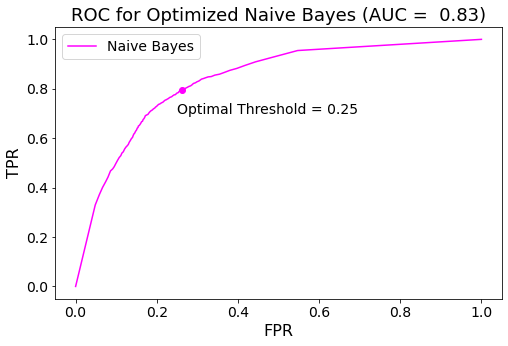

In [204]:
model_name = "Naive Bayes"
colors = {"Random Forest": "blue",
          "Logistic Regression": "green",
          "Naive Bayes": "magenta",
         }

# Make plot of ROC
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(df_roc_val["fpr"], df_roc_val["tpr"], 
        color=colors[model_name], 
        linestyle="solid",
        label=model_name
       );

# Find optimal threshold based on largest difference between TPR and FPR
df_roc_val_sorted = df_roc_val.sort_values(["diff"], ascending=False).reset_index()

# Get threshold, round to 2 decimal places
optimal_threshold = np.around(df_roc_val_sorted.loc[0, ["threshold"]]["threshold"], 2)

# Get fpr and tpr for optimal threshold
optimal_threshold_fpr = df_roc_val_sorted.loc[0, ["fpr"]]["fpr"]
optimal_threshold_tpr = df_roc_val_sorted.loc[0, ["tpr"]]["tpr"]

# Plot point for optimal threshold
ax.plot(optimal_threshold_fpr, 
        optimal_threshold_tpr, 
        color=colors[model_name],
        marker="o")

# Calculate AUC
def calc_AUC(df_roc_inp):
    
    df_roc_inp_sorted = df_roc_inp.sort_values(["fpr"])
    
    auc = np.trapz(y=df_roc_inp_sorted["tpr"], 
                   x=df_roc_inp_sorted["fpr"],
                  )
    
    return auc

auc_plot = np.around(calc_AUC(df_roc_val), decimals=2)

# Label graph
ax.set_xlabel("FPR", fontsize=16)
ax.set_ylabel("TPR", fontsize=16)
ax.set_title(f"ROC for Optimized {model_name} (AUC = {auc_plot: .2f})", 
             fontsize=18)

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

ax.legend(fontsize=14)
font = {
        # "family": "Arial",
        # "weight": "bold",
        "size": 14}

# Mess with text placement depending on the optimal threshold point
plt.text(0.25, 0.7, 
         f"Optimal Threshold = {optimal_threshold}", font)
plt.show()